In [1]:
import os
from glob import glob

from typing import Dict, List, Tuple
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import dask.array as da
import omnialigner as om
from omnialigner.omni_3D import Omni3D

from omnialigner.cache_files import StageSampleTag, StageTag
from tqdm import tqdm
plt = om.pl.plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
config_file = "/cluster/home/bqhu_jh/projects/omni/config/fair/config_prostate.yaml"

om_data = Omni3D(config_info=config_file)
overwrite_cache=False

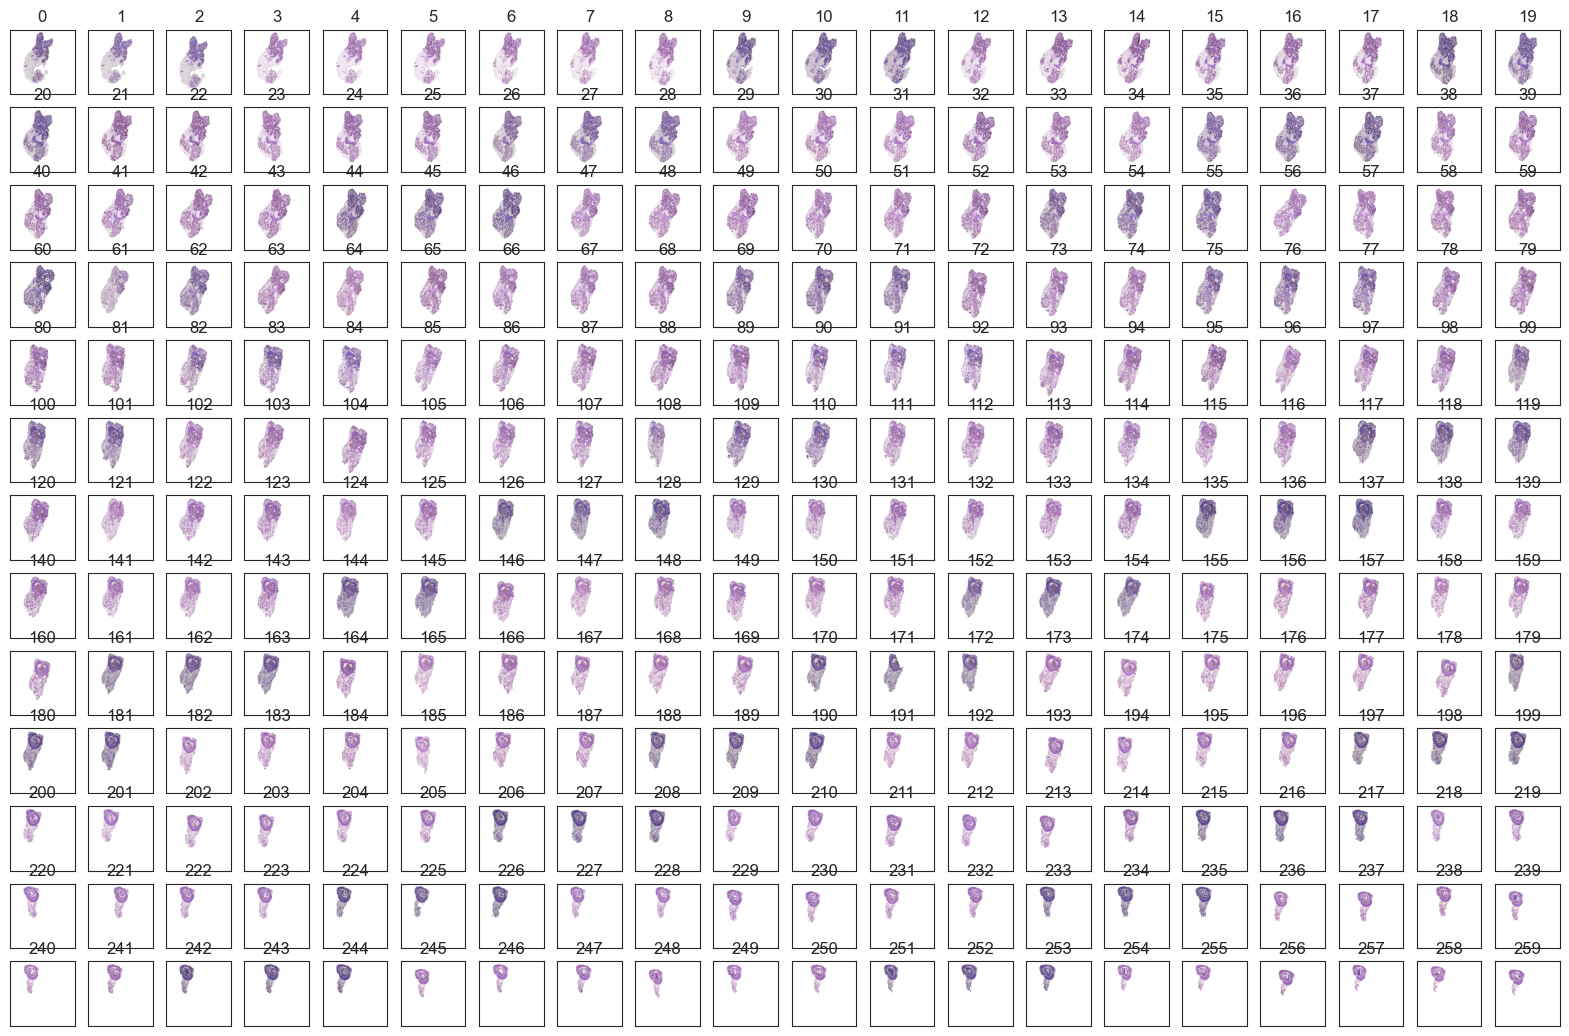

In [3]:
_ = om.pp.pad(om_data, overwrite_cache=overwrite_cache)
om.pl.plot_nchw_2d(om_data, aligned_tag="PAD")

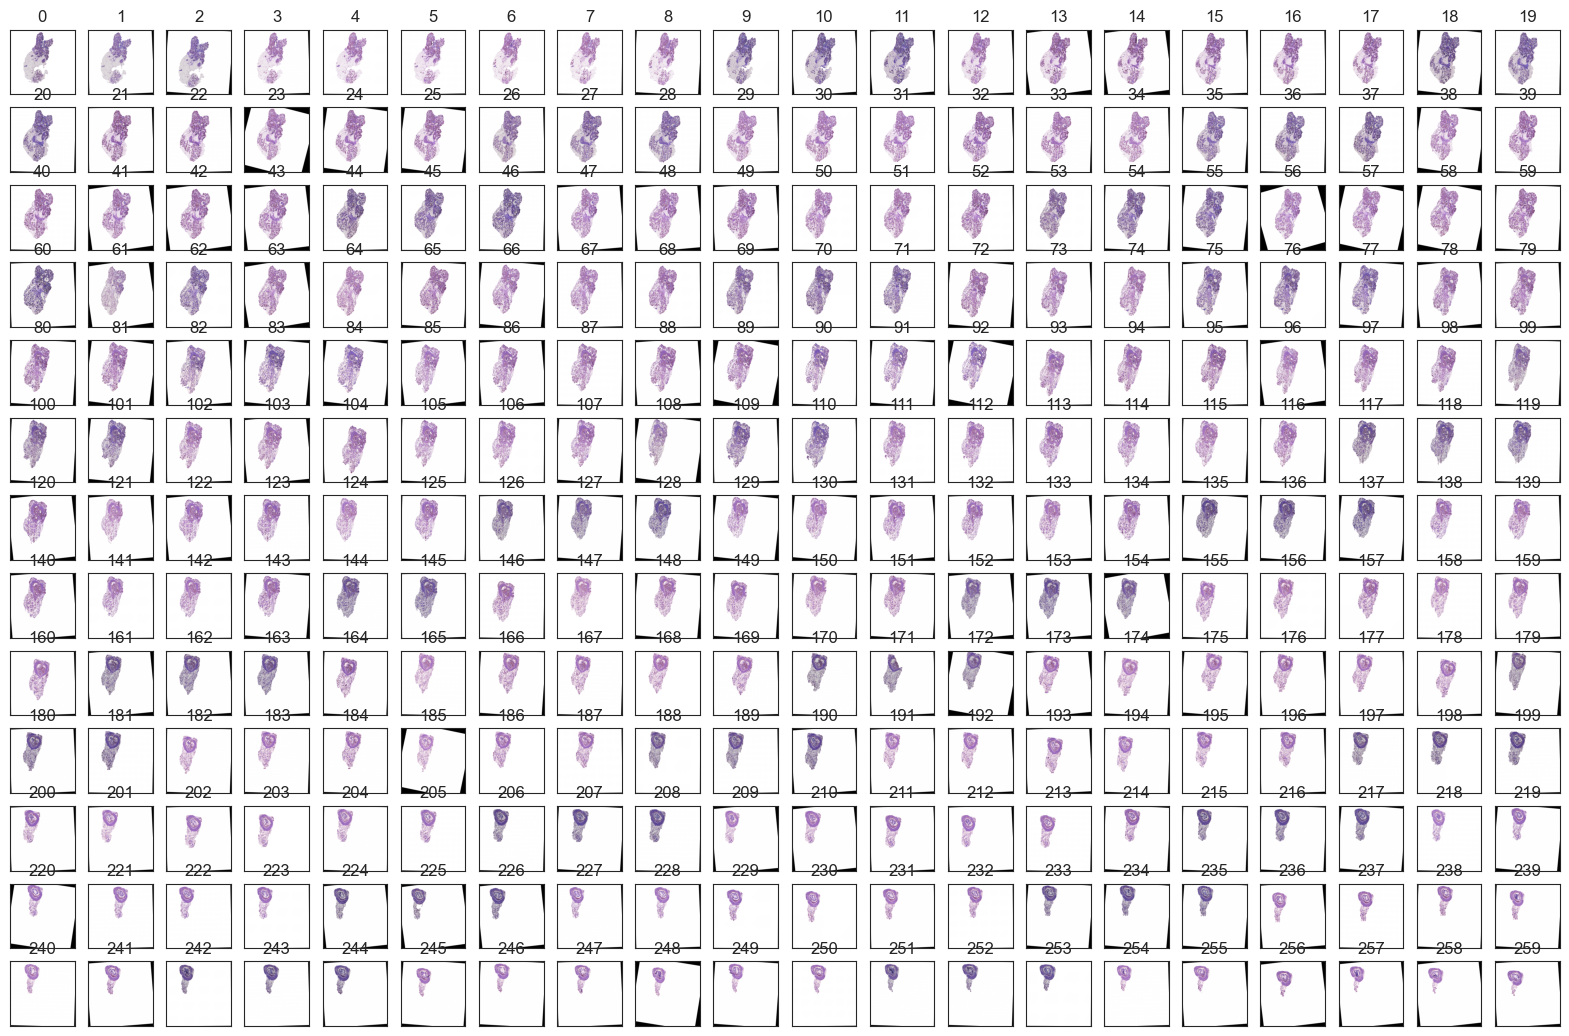

In [4]:
_ = om.align.stack(om_data, overwrite_cache=overwrite_cache)
om.pl.plot_nchw_2d(om_data, aligned_tag="STACK")

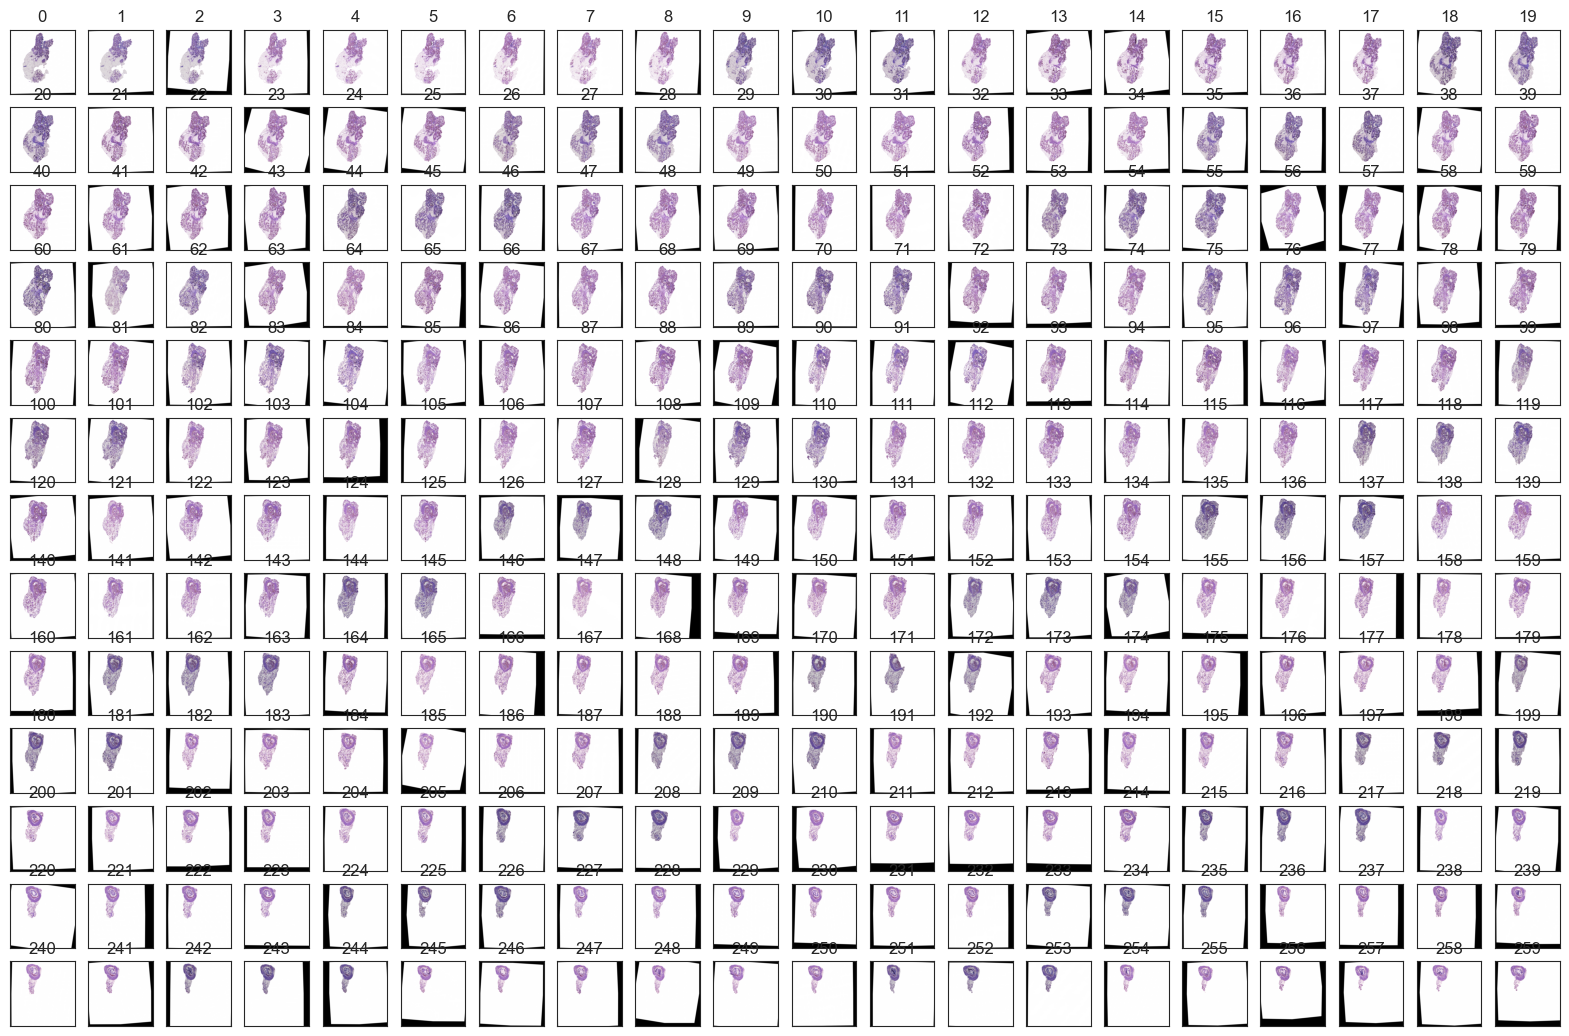

In [5]:
padded_tensor, l_kpts = om.align.affine(om_data, overwrite_cache=overwrite_cache)
om.pl.plot_nchw_2d(om_data, aligned_tag="AFFINE")

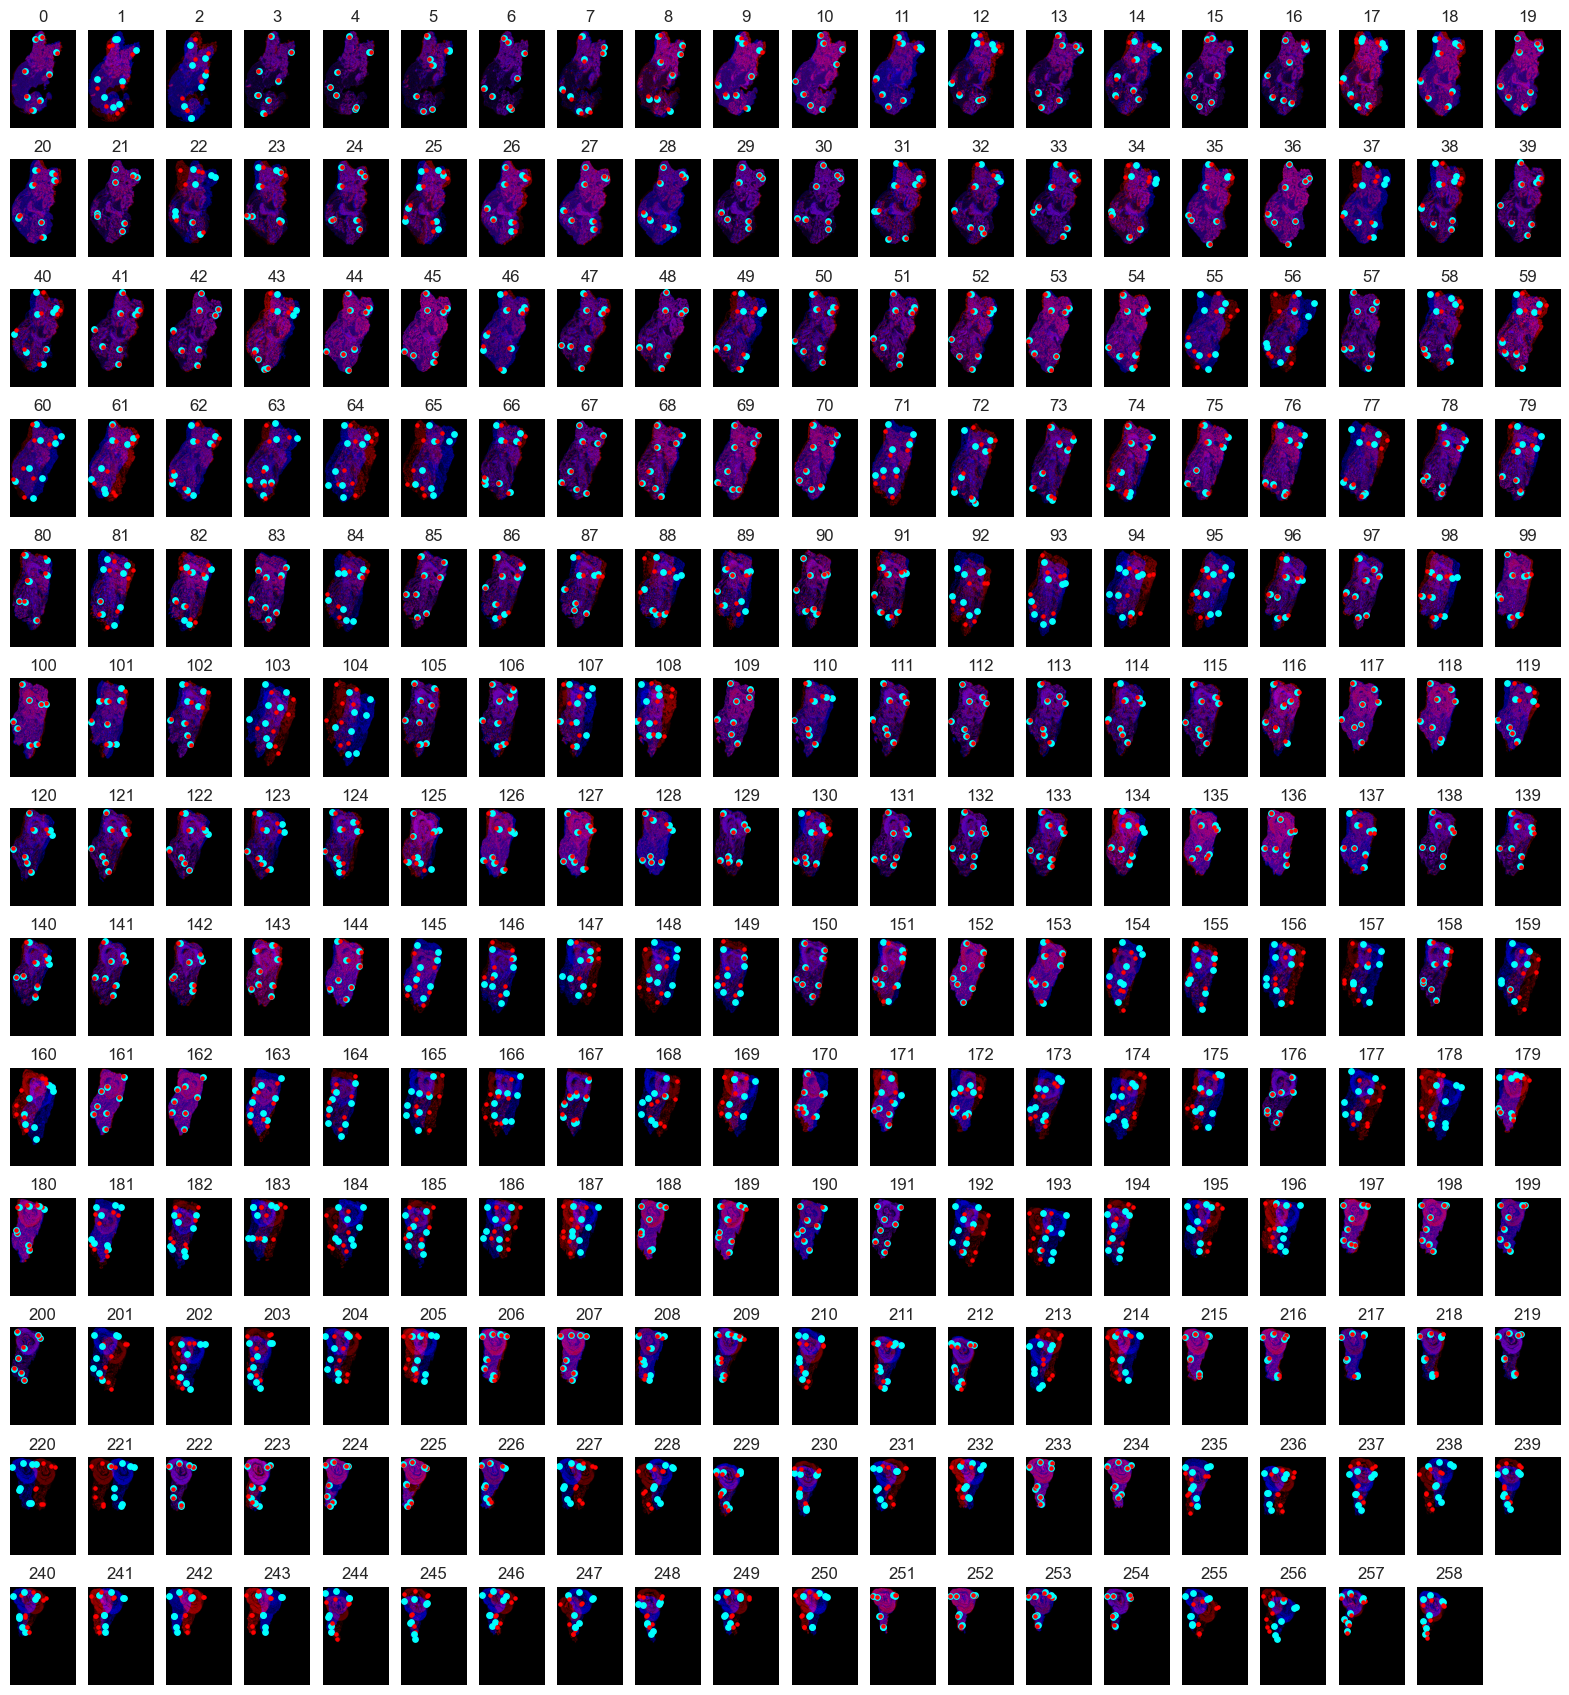

In [7]:
import pandas as pd

df_o1_csv = pd.read_csv("/cluster/home/bqhu_jh/projects/scGaussian3dGen/data/SupplementaryData_A_comparison_of_reconstruction_algorithms_for_3D_histology/Data_to_IDA/fiducialcoordinates_prostate_observer1.txt", sep="\t")

df_o2_csv = pd.read_csv("/cluster/home/bqhu_jh/projects/scGaussian3dGen/data/SupplementaryData_A_comparison_of_reconstruction_algorithms_for_3D_histology/Data_to_IDA/fiducialcoordinates_prostate_observer2.txt", sep="\t")

zoom_level = 3

fig = plt.figure(figsize=(20, 25))

i_layer = 0
idx = 0
l_kpt_pairs = []
for i_layer, idx in enumerate(range(len(om_data)-1)):
# for i_layer, idx in enumerate(range(4)):
    ax = fig.add_subplot(15, 20, i_layer+1)
    # ax = fig.add_subplot(1, 4, i_layer+1)
    da_arr_0 = om_data.load_tiff(idx, zoom_level=zoom_level)
    da_arr_1 = om_data.load_tiff(idx+1, zoom_level=zoom_level)

    da_out = 3*(255-da_arr_0.compute())
    da_out[:, :, 1] = 0
    da_out[:, :, 0] = 255-da_arr_1[:, :, 0]
    ax.imshow(da_out)

    np_line = df_o1_csv.iloc[idx].values[1:17]
    np_kpts1 = np_line.reshape(-1, 2)[0:4]
    ax.scatter(np_kpts1[:, 1]*om_data.sizes[zoom_level], np_kpts1[:, 0]*om_data.sizes[zoom_level], c="cyan", s=15)
    ax.set_title(f"{idx}")

    np_line = df_o1_csv.iloc[idx].values[1:17]
    np_kpts2 = np_line.reshape(-1, 2)[4:8]
    ax.scatter(np_kpts2[:, 1]*om_data.sizes[zoom_level], np_kpts2[:, 0]*om_data.sizes[zoom_level], c="red", s=5)


    np_line = df_o2_csv.iloc[idx].values[1:17]
    np_kpts1_ = np_line.reshape(-1, 2)[0:4]
    ax.scatter(np_kpts1_[:, 1]*om_data.sizes[zoom_level], np_kpts1_[:, 0]*om_data.sizes[zoom_level], c="cyan", s=15)
    ax.set_title(f"{idx}")
    ax.axis('off')
    
    np_line = df_o2_csv.iloc[idx].values[1:17]
    np_kpts2_ = np_line.reshape(-1, 2)[4:8]
    ax.scatter(np_kpts2_[:, 1]*om_data.sizes[zoom_level], np_kpts2_[:, 0]*om_data.sizes[zoom_level], c="red", s=5)

    np_k1 = np.vstack([np_kpts1, np_kpts1_])
    np_k2 = np.vstack([np_kpts2, np_kpts2_])

    l_kpt_pairs.append([np_k1[:, ::-1].astype(np.float32), np_k2[:, ::-1].astype(np.float32)])


torch.save(l_kpt_pairs, "./l_kpt_pairs_prostate.pth")


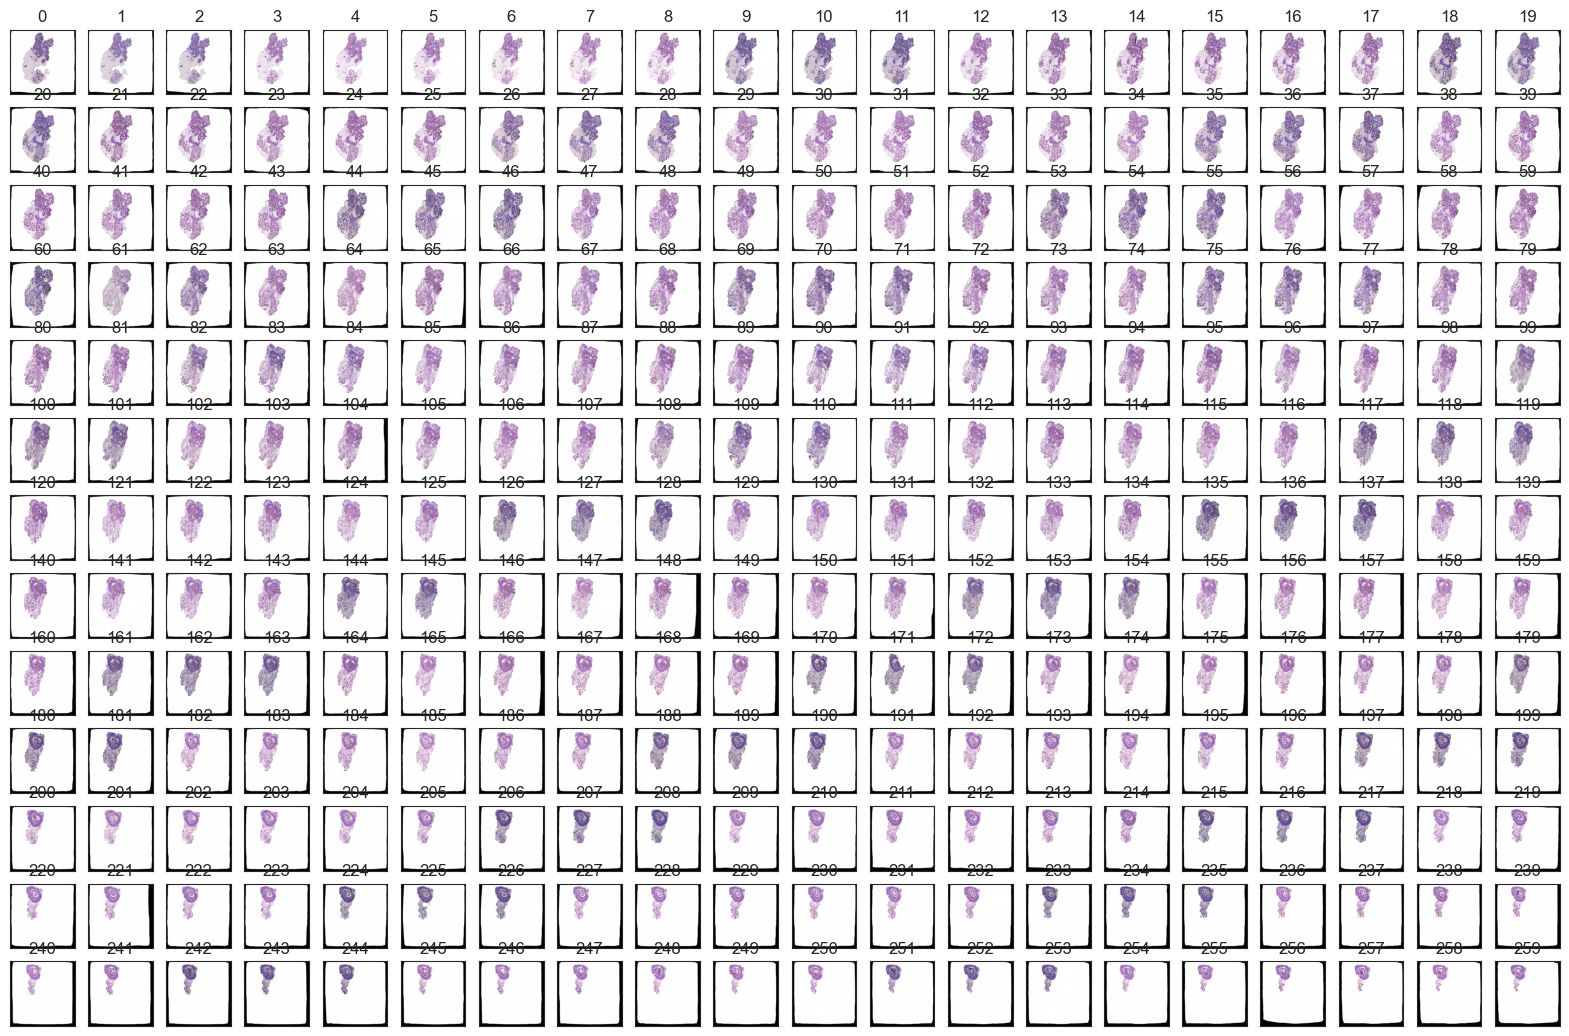

In [8]:
l_kpt_pair_eval = torch.load("./l_kpt_pairs_prostate.pth")

nonrigid_tensor, l_kpts_nonrigid = om.align.nonrigid(om_data, dense_dist_z=1, l_kpts_eval=l_kpt_pair_eval, overwrite_cache=overwrite_cache)

om.pl.plot_nchw_2d(om_data, aligned_tag="NONRIGID")

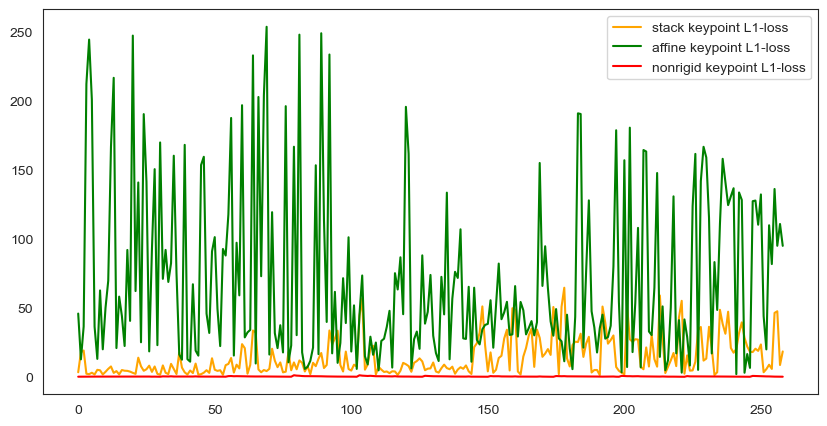

In [9]:
func_loss = lambda pair : torch.mean(torch.abs((pair[0] - pair[1])))
dict_file_name = StageTag.STACK.get_file_name(om_data.proj_info)
l_kpts = torch.load(dict_file_name["l_kpts_pairs"])
loss_kpts_stack = []
for idx_F in range(len(l_kpts)):    
    loss_kpts_stack.append(func_loss(l_kpts[idx_F]))


func_loss = lambda pair : torch.mean(torch.abs((pair[0]*om_data.max_size - pair[1]*om_data.max_size)))
dict_file_name = StageTag.AFFINE.get_file_name(om_data.proj_info)
l_kpts = torch.load(dict_file_name["affine_kpts"])
loss_kpts_affine = []
for idx_F in range(len(l_kpts)):
    loss_kpts_affine.append(func_loss(l_kpts[idx_F][0]))



dict_file_name = StageTag.NONRIGID.get_file_name(om_data.proj_info)
l_kpts = torch.load(dict_file_name["nonrigid_kpts"])
loss_kpts_nonrigid = []
for idx_F in range(len(l_kpts)):
    loss_kpts_nonrigid.append(func_loss(l_kpts[idx_F][0]))
    
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(loss_kpts_stack, label='stack keypoint L1-loss', color="orange")
ax1.plot(loss_kpts_affine, label='affine keypoint L1-loss', color="green")
ax1.plot(loss_kpts_nonrigid, label='nonrigid keypoint L1-loss', color="red")
ax1.legend()

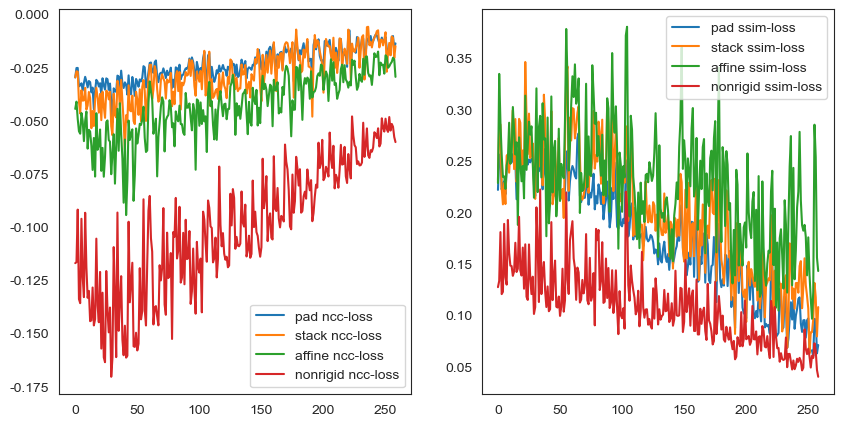

In [10]:
from omnialigner.align.models.loss import ncc_local, ssim_loss
def evaluate_image_loss(om_data: Omni3D, loss_image_func=ncc_local) -> Dict[StageTag, List[float]]:
    dict_loss_img = {}
    for stage in [StageTag.PAD, StageTag.STACK, StageTag.AFFINE, StageTag.NONRIGID]: 
        dict_file_name = stage.get_file_name(om_data.proj_info)
        padded_tensor = torch.load(dict_file_name["padded_tensor"])
        loss_img = []
        for idx_F in range(len(padded_tensor)-1):    
            loss_img.append(loss_image_func(padded_tensor[idx_F:idx_F+1], padded_tensor[idx_F+1:idx_F+2]))
        
        dict_loss_img[stage] = loss_img

    return dict_loss_img

dict_loss_img = evaluate_image_loss(om_data, ncc_local)
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(dict_loss_img[StageTag.PAD], label='pad ncc-loss')
ax1.plot(dict_loss_img[StageTag.STACK], label='stack ncc-loss')
ax1.plot(dict_loss_img[StageTag.AFFINE], label='affine ncc-loss')
ax1.plot(dict_loss_img[StageTag.NONRIGID], label='nonrigid ncc-loss')
ax1.legend()


dict_loss_img = evaluate_image_loss(om_data, ssim_loss)    
ax2 = fig.add_subplot(1,2,2)
ax2.plot(dict_loss_img[StageTag.PAD], label='pad ssim-loss')
ax2.plot(dict_loss_img[StageTag.STACK], label='stack ssim-loss')
ax2.plot(dict_loss_img[StageTag.AFFINE], label='affine ssim-loss')
ax2.plot(dict_loss_img[StageTag.NONRIGID], label='nonrigid ssim-loss')
ax2.legend()

100%|██████████| 260/260 [02:24<00:00,  1.79it/s]


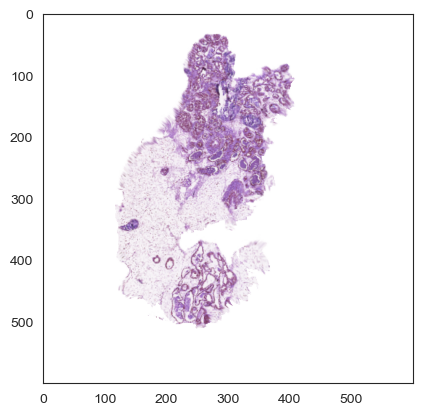

In [11]:
l_img_rgba = om.pl.generte_3d_rgba(om_data)
plt.imshow(l_img_rgba[3])

In [12]:
om.pl.plot_stack_rgba(l_img_rgba, down_scale=2)

260it [00:01, 236.35it/s]
INFO:wslink.backends.aiohttp:awaiting runner setup
INFO:wslink.backends.aiohttp:awaiting site startup
INFO:wslink.backends.aiohttp:Print WSLINK_READY_MSG
INFO:wslink.backends.aiohttp:Schedule auto shutdown with timout 0
INFO:wslink.backends.aiohttp:awaiting running future


Widget(value='<iframe src="/proxy/43893/index.html?ui=P_0x7f7d66d91120_0&reconnect=auto" class="pyvista" style…